In [1]:
from bus_sim import Simulation, BatchRunner
from utils import transpose_to_plot, mins_to_hours
import numpy as np

np.random.seed(seed=3001)

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import scipy.stats as sts

# Introduction

The following notebook uses an event-driven simulation implemented in Python to model a 15-stop public transport circuit. The motivating question behind the design and analysis of the simulation is, "How many buses should be on the route?". As an avid freerider of public transport (with multiple fines to my name), this exercise was both exciting and surprising, and I hope I can convey some of those reactions below.

## Event-Driven Simulation

In contrast to the agent-based paradigm where we taking discrete time steps, computing remainig event durations, and using some Manager class to schedule consecutive events, this simulation is "event-driven".

My attempt at a summary for this modeling approach is, "A simulation comprises a series of Events, which are timestamped Entities who conditionally execute Processes at their respective timestamp". My tagline, however, is "Events are timestamped Entities that conditionally schedule other Events". For example, at time 0, the BusStop entity triggers its passenger_arrival() process, which changes its state by updating the passengers in its bus stop queue, and scheduling *itself* after a duration sampled from the exponential distribution. 

The distinction might seem obvious or longwinded, but it took me some time to really wrap my head around, and led to an opinionated change in the design of the Event and Schedule class: the conditional logic of executing Processes is abstracted out to the Simulation class. This also made unit testing easier (which is messily bundled into Testing.ipynb, in this folder, if you're curious about dev process), but also made extending the model much easier.  

## A Theoretical Baseline (?)

To perform sanity checks on our model, it would be useful to have some pointers about the state of the simulation in the steady state. In an attempt to frame the scenario in the terms of Queuing theory, we can think of the system as 15 parallel M/G/1 queues. However, this assumption quickly breaks down. 

First, we model service times not for the individual customer but for the $n$ customers that are to board the bus, which itself is a function of the remaining capacity in the bus, which itself depends on Passengers selecting their destination stops at random, within a 7 stop limit. As there is a probabilistic dependency between events, modeling the service rate distribution G is not as simple as dividing and normalizing the Normal distribution by n. In other words, n is elusive and I don't have enough knowledge of probability to find a closed-form expression for it. 

This motivates finding other rules of thumb - derived from common sense and good judgment, but also patterns in the implementation - to validate our simulation. With this in mind, I will briefly go over our Entities and their Processes with an emphasis on modeling theory (as we don't want a rehash of docstrings):


## Entities and Processes
### Passenger
A data container, to eventually compute the passenger waiting time variable. Her destination stop is at most 7 stops from where she boards, which is correctly bounded through the modulo operator. Also assumes number of BusStops simulation parameter is fixed at 15 stops. 

### BusStop
Maintains a bus queue of Passengers with a given stop index (1 to 15), and an unconditional passenger_arrival() process, which adds a new passenger to the bus queue with exponential inter-arrival times.

The Bus queue is also a heap, as we want to load passengers on a first come, first served basis during the Bus.load_passengers() process (see below). Loading the longest waiting customer first is just an inexpensive matter of repeatedly popping off the heap. 

An interesting corollary of having just one process that schedules exponentially-separated passenger arrivals is that **a series of BusStop Events will see an exponential distribution**, with the same lambda, on the Event Schedule: a very robust heuristic to see if our Schedule is working as intended. 

### Bus
A Bus maintains capacity within a capacity of 130. Its processes are the most complicated as they are all conditional on the state of either the Bus or the BusStop, and interact with BusStop as well as system state.

The first process unloads passengers at a BusStop, if the Passengers' destination stop matches the BusStop stop_index. It then loads passengers on a first come, first serve basis within capacity limit. It then schedules its next arrival, which factors in the loading/unloading delay. 

We were provided a set of prior normal(esque) distributions that collectvely describe transit times - the travel, embarkation and disembarkation times - that lend further stochasticity to the simulation. These are encoded as lambda functions within class attributes, such that we get fresh/un-frozen samples when we call them. We use truncated normal distributions as opposed to the suggested normal distributions as we want the support to be > 0, since we can only have positive embarkation/disembarkation/travel times. 

The embarkation and disembarkation times are also a function of the number to embark and disembark, respectively, evincing the conditional dependence on the state of the Bus and BusStop. 

### Stats
A data collector for system variables, sampling data from the system after rescheduling itself every fixed interval. Since events represent changes to the state of the system, sampling just during events creates some sampling bias if we want to measure averages over periods. 

## Simuation
A class to instantiate each Entity, initialize their starting Events on an overarching schedule, run the simulation, collect data and produce summary plots. Fixed parameters are the end time, a full day of 1440 minutes, 15 bus stops, as well as all the distribution parameters provided.

## BatchRunner
A class to answer our motivating question. Runs and collects data on repeated trials of Simulations that increment the number of buses from 1 to 15. 


# A Hard Day's A-Gonna Fall
Here we overburden a single bus with the duty of 15 stops. 

In [2]:
sim = Simulation(total_buses= 1)
sim.run()

KstestResult(statistic=0.01633529187296079, pvalue=0.8454216559052359)


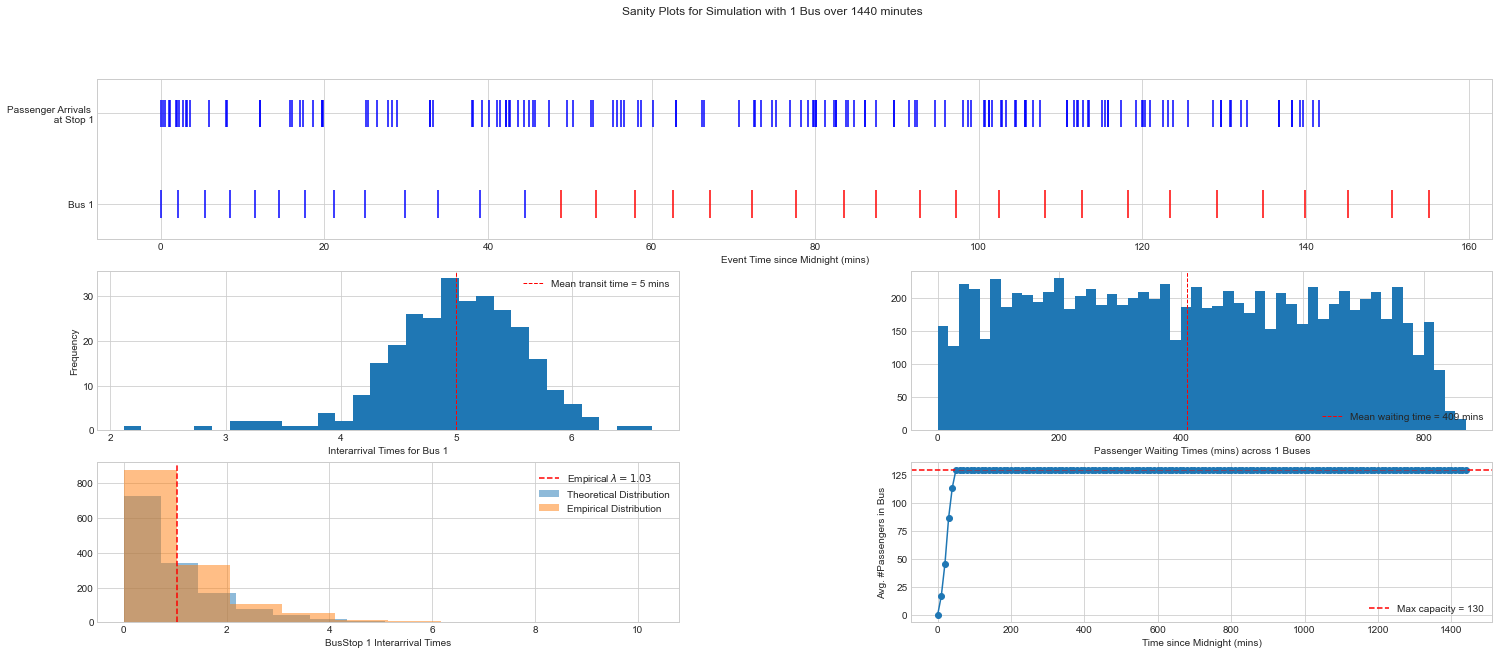

In [3]:
ks, wait, burden = sim.sanity_plot()
print(ks)

The top-most Event Plot represents the Schedule during a nascent period (t ~< 160 minutes) over which a single instance of Bus and BusStop's Events are tracked. These are specifically Bus with name_ 1 and BusStop with stop_index 1 instances. A Bus Event is colored red with the Bus is full. 

Notice that Passenger Arrivals at Stop 1 are irregularly spaced, though without strong variation on the number of arrivals over a 25 minute sub-interval. Meanwhile, spacing between Bus Events gradually increase from about 9 per 25 minute interval to 5 per 25 minute interval as the bus becomes full. During this early period, we have suggestions that the Schedule is working as intended, though we can quantify this a little better.

As mentioned in the section above, a correctly-functioning Schedule schedules a BusStop instance according to an exponential distribution with lambda = 1. On the bottom left interarrival histogram, we layer over a theoretical exponential distribution with the same Lambda (=1) and assess goodness of fit by computing a single-sample KS test and the empirical mean. Each of these are very positive: the theoretical and empirical distributions overlap well, the empirial mean is 1.01, and the KS test has a high p-value of 0.84 (the null hypothesis is that the samples were drawn from the same distributions, so the higher p-value, the better). 

While we can establish that the machinery - event scheduling and processing logic - of the simulation work, to assess its validity we need to make a few educated guesses about what expect. 

We know that a system with n BusStops with identitically distributed arrival proceesss ~ Exp(k) has an arrival rate to the system with a distribution ~ Beta(n, k) = Beta(15, 1). The expected value happens to be nk = 15 arrivals/min. So we know vaguely enough that a bus with a 130 capacity will quickly become full, and that a full bus will lead to longer waiting times, first because the transit time will increase as more people get on/off at each stop, and second because the Bus is simply full and can't take on more than a "handful" at a time. 

Using the event plot, the Bus first becomes full at about t = 50 minutes, after which the Bus remains full until the end of the simulation (indicated by the bottom right plot). So we know *how* quickly it fills: but what is the effect of a full bus on waiting times? First, the expected transit duration for a bus goes from about 2 minutes (with low passengers to load/unload) to about 5 minutes (middle left plot): the normal distribution of transit time is "nudged" to the right. Additionally, Passenger wait times are flatly distributed (middle right plot), which plausibly suggests that queues are growing without bound across stops. We can test this prediction by re-running the simulation over two days  (48*60 = 2880 minutes):

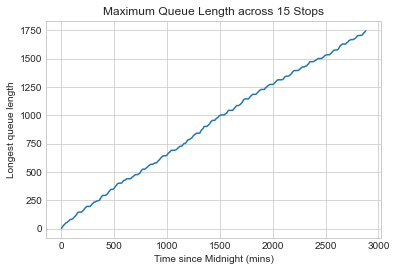

In [4]:
sim = Simulation(total_buses= 1, final_time=48*60)
sim.run()
sim.max_queue_plot()

Now a Day In The Life, with a sensible number of buses (10),

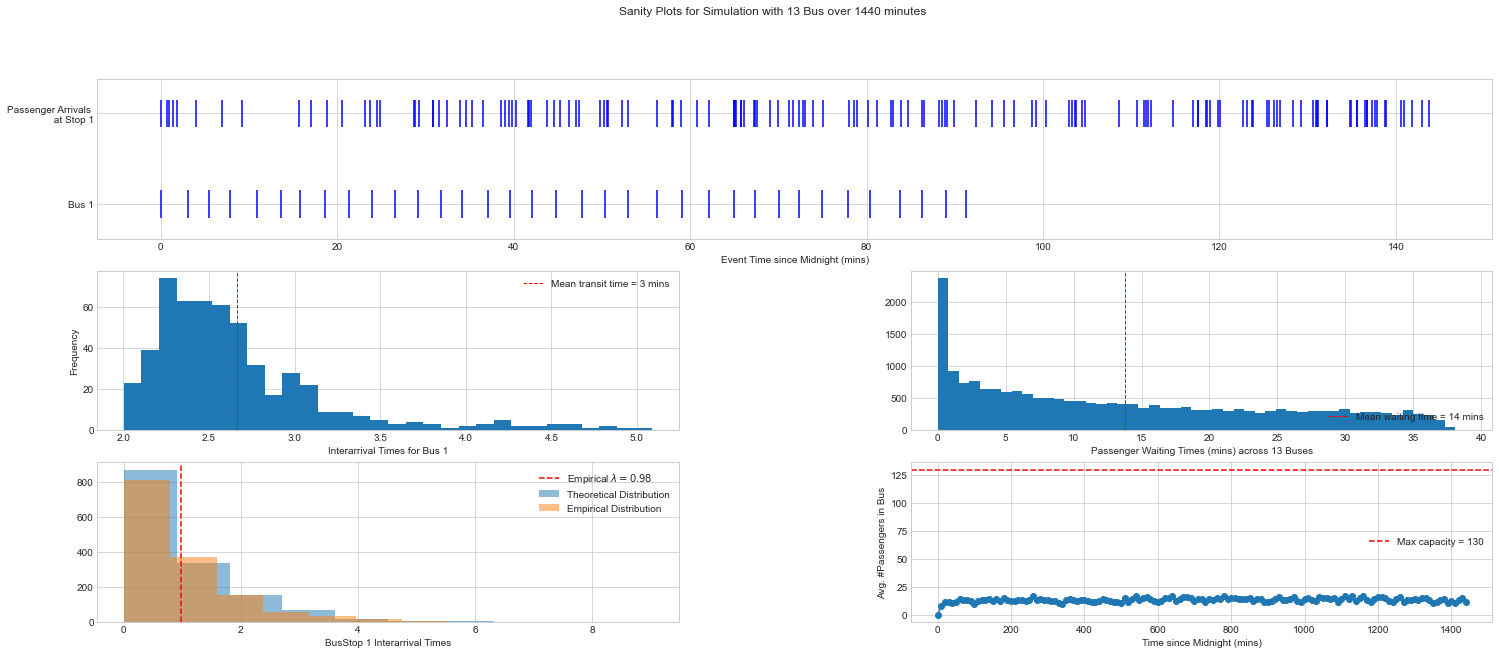

In [5]:
sim = Simulation(total_buses= 13)
sim.run()
ks, wait, burden = sim.sanity_plot()

In contrast to an overburdended bus, this never gets full. Heuristics about the simulation functioning well remain, and continue to be promising, here: the empirical lambda for BusStop 1 Events are exponentially distributed, and the Bus interarrival time distribution isn't nudged too far from its "passengerless" Normal distribution with mean 2. Notably, passenger wait times have a power-law distribution: passengers will experience minimal (<2) waiting times most frequntly, though handfuls will experience long (> mean of 15min) waiting times because of long, fairly fat tails. 

(Note: the Event Plot's Bus 1 events appear truncated as an artefact of hardcoding a sample of the first 35 Bus events. As the interarrival times do not increase as much here relative to the run with 1 Bus, the events appear to stop entirely.)

## Extension Model

Relatively secure with how the simulation is functioning, we now make two updates to the variables and processing logic of the sim. First, we let the arrival rate (lambda) vary by 1.2 + cos(pi(t-7)/6), where t is in hours. 

In [6]:
sim = Simulation (total_buses  = 1, extended= True)
sim.run()

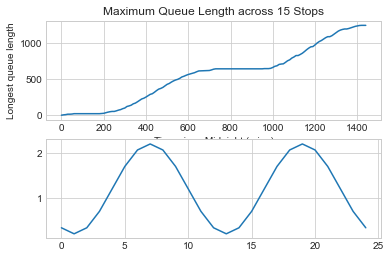

In [7]:
plt.subplots(2,1)
plt.subplot(2,1,1)
sim.max_queue_plot()
plt.subplot(2,1,2)
t = mins_to_hours(np.linspace(0,1440, 1000))
y = 1.2 + np.cos(np.pi*(t -7)/6)
plt.plot(t,y)
#sim.sanity_plot()

Maximum queue length still grows unbounded, albeit regulated by the sinusoidal variation of lambda with hour of day. 

Now we let passengers get annoyed and leave if they wait for more than 10 mins, and if there are at least 20 people in front of them. These extensions are implemented with the pythonically-named methods get_annoyed_and_leave() and annoyed() in BusStop and Passnger classes respectively.

In [8]:
# We continue to run for just one bus to compare and contrast:
sim = Simulation (total_buses  = 1, extended= True, pass_extended=True)
sim.run()

Text(0.5, 0, 'Time of Day (hours since midnight)')

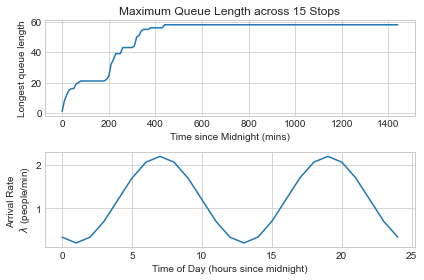

In [9]:
plt.subplots(2,1,tight_layout = True)
plt.subplot(2,1,1)
sim.max_queue_plot()
plt.subplot(2,1,2)
t = mins_to_hours(np.linspace(0,1440, 1000))
y = 1.2 + np.cos(np.pi*(t -7)/6)
plt.plot(t,y)
plt.ylabel("Arrival Rate \n $\lambda$ (people/min)")
plt.xlabel("Time of Day (hours since midnight)")

Now, the unbounded growth diasppears: the maximum queue lenth on any stop tops out at 60 passengers. Might be a magic number: plotting annoyed passenger departures might elucidate things.

Text(0, 0.5, 'Arrival Rate \n $\\lambda$ (people/min)')

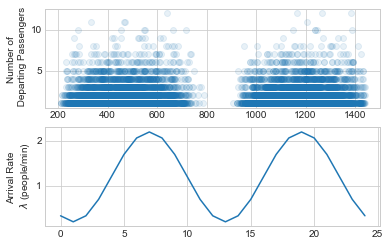

In [10]:
plot_data = transpose_to_plot(sim.annoyed)

plt.subplots(2,1)
plt.subplot(2,1,1)

x = plot_data[0]
y = [len(plot_data[1][i]) for i in range(len(plot_data[1]))]
plt.scatter(x,y, alpha = 0.1)
plt.ylabel("Number of \n Departing Passengers")

plt.subplot(2,1,2)
t = mins_to_hours(np.linspace(0,1440, 1000))
y = 1.2 + np.cos(np.pi*(t -7)/6)
plt.plot(t,y)
plt.ylabel("Arrival Rate \n $\lambda$ (people/min)")

Passenger departues over time are highly regulated by the variation in the arrival rate over time. When Lambda ~= 0, we see almost no departures, perhaps because the service rate during that period for the system exceeds the arrival rate, such that no queue exceeds 20 people. 

# How Many Buses? 

For each plot betlow, error bars represent 95% CIs over the expected values.

In [ ]:
batch = BatchRunner(total_buses=15, run_count = 30)
batch.batch_run()

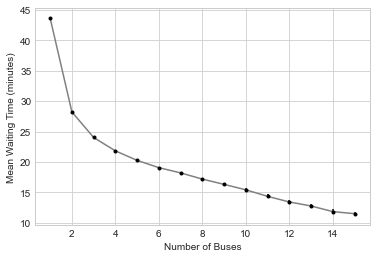

In [14]:
batch.wait_times_plot()

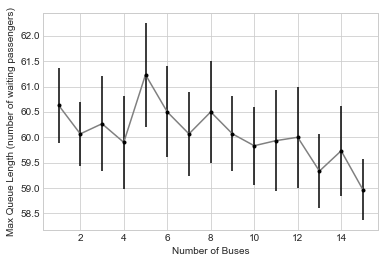

In [15]:
batch.max_queue_plot()

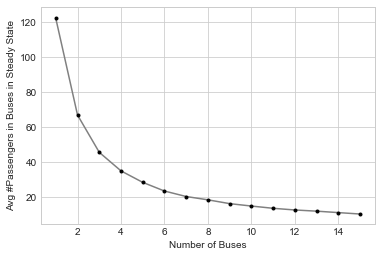

In [16]:
batch.mean_passengers_plot()

Differences in max queue length, because of annoyed passenger departures, are negligible. While mean waiting time reduces by over 50% in the first 5 hours, it reduces by 20% in the next 5 hours, then about 20% again over the next 5 hours. The absolute reductions, however, diminish by 25, 5 and then ~3 hours respectively. We find a similar trend for average passengers in buses, which measures average bus congestion: a higher average implies a more unpleasant experience for travellers. 

As there are diminishing absolute returns to increasing the number of buses, we need to think about adding a bus as a kind of cost, and then optimize for cost minimization as a function of both mean waiting time and number of buses:

c(b, w) = a*b + b*w

The coefficients represent a would-you-rather: if we increase the cost of b, we disfavor decreases in waiting time. Conversely, if we decrease the cost of b, we favor decreases in waiting time. Since this is just an estimation problem, lets raise the cost of b, as public transport authorities are generally tasked with managing complex infrastructure with minimal budgets:

Text(0.5, 1.0, 'Cost Function')

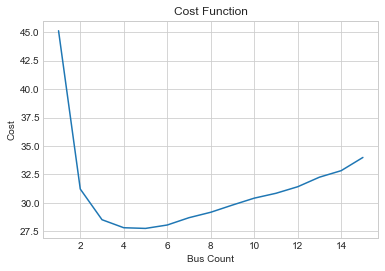

In [17]:
p = batch.sim_data

costs = []

for option in p.items():
    b = option[0]
    w = option[1]["avg_wait"][0]

    costs.append(1.5*b + 1*w)

plt.plot(p.keys(), costs)
plt.xlabel("Bus Count")
plt.ylabel("Cost")
plt.title("Cost Function")

We observe a global minima at 5 Buses, which is what I would recommend to serve the public transport  circuit: mean waiting times are moderate (~22 mins/passenger), and there are relatively few buses to manage. While this mean waiting time sounds extreme, we have to remember (from A Day in The Life above) that waiting times are power-law distributed when buses serve under-capacity over the course of the day. This implies that > 50% of passengers will experience shorter waiting times. 